# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [134]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import numpy as np

In [15]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [16]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [17]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [18]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [19]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [20]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [21]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [22]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [23]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [24]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [25]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [26]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

### segragating datapoints w.r.t calss labels and sampling optimum number of data points 

In [27]:
zero_class=final[final.Score==0]
print(zero_class['Score'].value_counts())
print(zero_class.shape)
one_class=final[final.Score==1]
print(one_class['Score'].value_counts())
print(one_class.shape)

0    54744
Name: Score, dtype: int64
(54744, 10)
1    293516
Name: Score, dtype: int64
(293516, 10)


In [28]:
one_class1=one_class.sample(n=50000)
zero_class1=zero_class.sample(n=50000)
print(zero_class1.shape)
print(one_class1.shape)
combined_frame=pd.concat([zero_class1,one_class1])
print(combined_frame.shape)
final_new_frame=combined_frame.sample(frac=1)
print(type(final_new_frame))
print(final_new_frame.shape)
print(final_new_frame['Score'].value_counts())

(50000, 10)
(50000, 10)
(100000, 10)
<class 'pandas.core.frame.DataFrame'>
(100000, 10)
1    50000
0    50000
Name: Score, dtype: int64


In [29]:
# 1.11 -this here cotinuation https://stackoverflow.com/a/47091490/4084039
import re
from bs4 import BeautifulSoup

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])


from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final_new_frame['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    
j=0
for i in tqdm(preprocessed_reviews):
    j=j+1
print(j)

100%|█████████████████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 2085037.93it/s]


100000


# [4] Featurization

## [4.1] BAG OF WORDS

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(preprocessed_reviews, final_new_frame['Score'], test_size=0.33)

In [32]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)

X_train_bow = count_vect.transform(X_train)
X_test_bow = count_vect.transform(X_test)

## [4.3] TF-IDF

In [33]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)


X_train_tfidf = tf_idf_vect.transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)

## [4.4] Word2Vec

In [88]:
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [89]:
w2v_words = list(w2v_model.wv.vocab)

In [90]:
sent_vectors_train = [];
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])



list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
    
print(type(list_of_sentance_test[0]))
sent_vectors_test = [];
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50) 
    cnt_words =0; 
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 67000/67000 [02:00<00:00, 557.63it/s]


(67000, 50)
[-0.2096579   0.74643946 -0.13452312 -0.14210329  0.17900307 -0.6427729
  0.35569162 -0.17189059  0.51093686  0.56631128  0.3203314   0.35820583
 -0.30567669 -0.80790245  0.29229877 -0.21291003  0.32799549 -0.1152861
  0.75045465  0.01839878 -0.00120161 -0.603297   -1.0905942   0.45734186
  0.15621854 -0.10261358  0.12455393 -0.34032977  0.15338642 -0.19793672
 -0.47641966 -0.07546129 -0.21991669 -0.52092773  1.06983955 -0.58082413
  0.19440258  0.12304332 -0.2422734   0.38284736  0.49226924  0.21719786
 -0.28972629  0.831094   -0.29331166 -0.22280866  0.68282657 -0.01618746
 -0.6202977   0.22974789]
<class 'list'>


100%|███████████████████████████████████████████████████████████████████████████| 33000/33000 [01:14<00:00, 445.58it/s]


(33000, 50)
[ 0.44169859  0.37461017 -0.29833066  0.02321706  0.29400228 -0.41497254
  1.05175292 -0.40617922  0.10471929  0.77458885 -0.48208172 -0.3827599
 -0.20978637 -0.83367562 -0.06170998  0.15599539  0.04181822  0.58836327
  0.44539704  0.63398274  0.15720507 -0.72752712 -1.63728129  0.64009628
  0.20652325  0.19841494  0.35867145 -0.32723437 -0.18563617 -0.94686239
 -0.35886203 -0.00499384 -0.03252504 -0.761088    0.53497802  0.02629275
  0.84863871 -0.42665874 -0.20144774  0.99379432 -0.03978634 -0.22772801
  0.1764493  -0.03082351 -0.19765201  0.77181638  1.12513404  0.63405364
 -0.80104088  0.32795946]


In [35]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8693093061447144), ('good', 0.8389817476272583), ('fantastic', 0.8339287638664246), ('excellent', 0.8069465160369873), ('terrific', 0.8052792549133301), ('wonderful', 0.7870060205459595), ('perfect', 0.7778894901275635), ('amazing', 0.7696285843849182), ('fabulous', 0.687727689743042), ('nice', 0.686516284942627)]
[('nastiest', 0.8576740622520447), ('greatest', 0.7369765043258667), ('best', 0.7322348952293396), ('disgusting', 0.7011551856994629), ('tastiest', 0.6993281841278076), ('weakest', 0.682689368724823), ('foulest', 0.6803052425384521), ('terrible', 0.6354975700378418), ('saltiest', 0.6299499869346619), ('worse', 0.6202494502067566)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  19461
sample words  ['appalling', 'anyone', 'would', 'produce', 'product', 'sell', 'food', 'people', 'eat', 'not', 'support', 'misguided', 'notion', 'something', 'could', 'considered', 'even', 'go', 'far', 'say', 'enjoy', 'eating', 'regular', 'basis', 'made', 'meat', 'faced', 'no', 'viable', 'conclusion', 'think', 'products', 'rejected', 'dog', 'factory', 'since', 'kind', 'weird', 'joke', 'thing', 'smell', 'gravy', 'label', 'mean', 'slime', 'gross', 'spam', 'many', 'questions', 'arm']


In [37]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [03:23<00:00, 491.97it/s]


100000
50


### [4.4.1.2] TFIDF weighted W2v

In [38]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [39]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [50:03<00:00, 33.30it/s]


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [48]:
x=[]
for i in range(1,33):
    x.append(i)
   

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

RF1=RandomForestClassifier( n_jobs=-1,class_weight="balanced")
parameters ={'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200],'max_depth':x}
clf1 = GridSearchCV(RF1, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf1.fit(X_train_bow, y_train)
print(clf1.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=32, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


In [146]:
max_depth_list = list(clf1.cv_results_['param_max_depth'].data)
n_estimators_list = list(clf1.cv_results_['param_n_estimators'].data)
train_Auc_score=clf1.cv_results_['mean_train_score']
cv_Auc_score=clf1.cv_results_['mean_test_score']
train_data=pd.DataFrame(data={'n_estimators':n_estimators_list, 'Max Depth':max_depth_list, 'AUC':train_Auc_score})
cv_data = pd.DataFrame(data={'n_estimators':n_estimators_list, 'Max Depth':max_depth_list, 'AUC':cv_Auc_score})

In [147]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np

x1 = n_estimators_list
y1 = max_depth_list
z1 = train_Auc_score

x2 = n_estimators_list
y2 = max_depth_list
z2 = cv_Auc_score

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

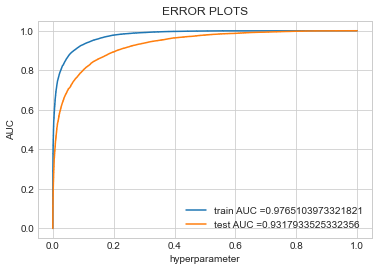

In [56]:
from sklearn.metrics import roc_curve, auc


RF2=RandomForestClassifier(n_estimators=200,max_depth=32,n_jobs=-1,class_weight="balanced")
RF2.fit(X_train_bow, y_train)


train_fpr, train_tpr, thresholds = roc_curve(y_train,RF2.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,RF2.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Train confusion matrix
[[29689  3809]
 [ 2005 31497]]
Test confusion matrix
[[13949  2553]
 [ 2293 14205]]


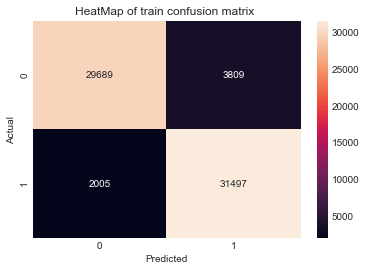

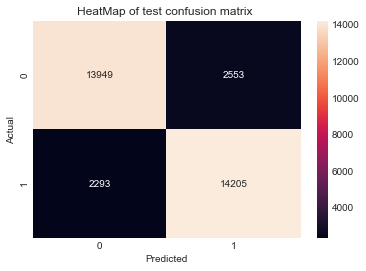

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

print("Train confusion matrix")
x=confusion_matrix(y_train, RF2.predict(X_train_bow))
y=confusion_matrix(y_test, RF2.predict(X_test_bow))
print(x)
print("Test confusion matrix")
print(y)


ax = plt.axes()
sns.heatmap(x, ax = ax,annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.set_title("HeatMap of train confusion matrix ")
plt.show()

ax = plt.axes()
sns.heatmap(y, ax = ax,annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.set_title("HeatMap of test confusion matrix ")
plt.show()

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

In [63]:
FI=RF2.feature_importances_

FeatInd=np.argsort(FI)
Fnames=count_vect.get_feature_names()
topimp=FeatInd[-20:]
imp=[]
for i in topimp:
    imp.append(Fnames[i])

print("Top 20 important features")
print("========================")
print("")
print(imp)

Top 20 important features

['product', 'terrible', 'loves', 'favorite', 'awful', 'thought', 'wonderful', 'highly', 'waste', 'worst', 'money', 'bad', 'perfect', 'would', 'delicious', 'disappointed', 'love', 'best', 'great', 'not']


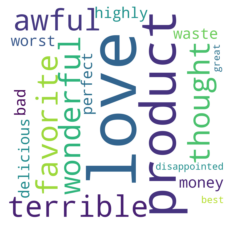

In [69]:
from wordcloud import WordCloud
text=""
for word in imp:
    text = text + " " + word

wordcloud = WordCloud(width=1000, height=1000,background_color="white").generate(text) 
plt.figure() 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show()

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [72]:
x=[]
for i in range(1,33):
    x.append(i)
   

In [73]:
RF3=RandomForestClassifier( n_jobs=-1,class_weight="balanced")
parameters ={'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200],'max_depth':x}
clf2 = GridSearchCV(RF3, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf2.fit(X_train_tfidf, y_train)
print(clf2.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=32, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


In [148]:
max_depth_list = list(clf2.cv_results_['param_max_depth'].data)
n_estimators_list = list(clf2.cv_results_['param_n_estimators'].data)
train_Auc_score=clf2.cv_results_['mean_train_score']
cv_Auc_score=clf2.cv_results_['mean_test_score']
train_data=pd.DataFrame(data={'n_estimators':n_estimators_list, 'Max Depth':max_depth_list, 'AUC':train_Auc_score})
cv_data = pd.DataFrame(data={'n_estimators':n_estimators_list, 'Max Depth':max_depth_list, 'AUC':cv_Auc_score})

In [149]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
import numpy as np

x1 = n_estimators_list
y1 = max_depth_list
z1 = train_Auc_score

x2 = n_estimators_list
y2 = max_depth_list
z2 = cv_Auc_score

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

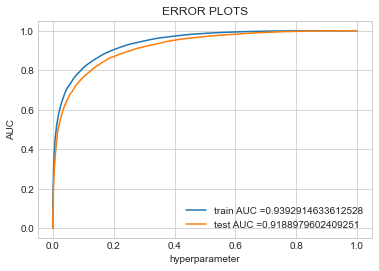

Train confusion matrix
[[27550  5948]
 [ 3695 29807]]
Test confusion matrix
[[13394  3108]
 [ 2262 14236]]


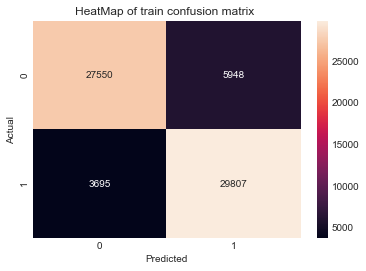

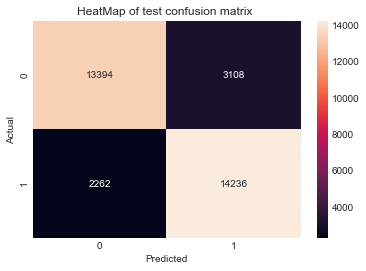

In [83]:
RF5=RandomForestClassifier(n_estimators=200,max_depth=13,n_jobs=-1,class_weight="balanced")
RF5.fit(X_train_tfidf, y_train)


train_fpr, train_tpr, thresholds = roc_curve(y_train,RF5.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,RF5.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("Train confusion matrix")
x=confusion_matrix(y_train, RF5.predict(X_train_tfidf))
y=confusion_matrix(y_test, RF5.predict(X_test_tfidf))
print(x)
print("Test confusion matrix")
print(y)


ax = plt.axes()
sns.heatmap(x, ax = ax,annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.set_title("HeatMap of train confusion matrix ")
plt.show()

ax = plt.axes()
sns.heatmap(y, ax = ax,annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.set_title("HeatMap of test confusion matrix ")
plt.show()

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

In [86]:
FI=RF5.feature_importances_

FeatInd=np.argsort(FI)
Fnames=tf_idf_vect.get_feature_names()
topimp=FeatInd[-20:]
imp=[]
for i in topimp:
    imp.append(Fnames[i])

print("Top 20 important features")
print("========================")
print("")
print(imp)

Top 20 important features

['easy', 'loves', 'return', 'money', 'would not', 'wonderful', 'awful', 'highly recommend', 'would', 'waste', 'not even', 'worst', 'delicious', 'not buy', 'love', 'bad', 'disappointed', 'best', 'great', 'not']


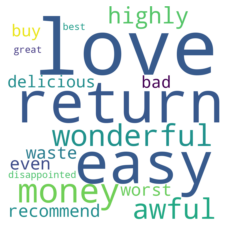

In [87]:
from wordcloud import WordCloud
text=""
for word in imp:
    text = text + " " + word

wordcloud = WordCloud(width=1000, height=1000,background_color="white").generate(text) 
plt.figure() 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show()

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [91]:
x=[]
for i in range(1,33):
    x.append(i)

In [92]:
RF6=RandomForestClassifier( n_jobs=-1,class_weight="balanced")
parameters ={'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200],'max_depth':x}
clf3 = GridSearchCV(RF6, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf3.fit(sent_vectors_train, y_train)
print(clf3.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


In [150]:
max_depth_list = list(clf3.cv_results_['param_max_depth'].data)
n_estimators_list = list(clf3.cv_results_['param_n_estimators'].data)
train_Auc_score=clf3.cv_results_['mean_train_score']
cv_Auc_score=clf3.cv_results_['mean_test_score']
train_data=pd.DataFrame(data={'n_estimators':n_estimators_list, 'Max Depth':max_depth_list, 'AUC':train_Auc_score})
cv_data = pd.DataFrame(data={'n_estimators':n_estimators_list, 'Max Depth':max_depth_list, 'AUC':cv_Auc_score})

In [151]:
x1 = n_estimators_list
y1 = max_depth_list
z1 = train_Auc_score

x2 = n_estimators_list
y2 = max_depth_list
z2 = cv_Auc_score

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

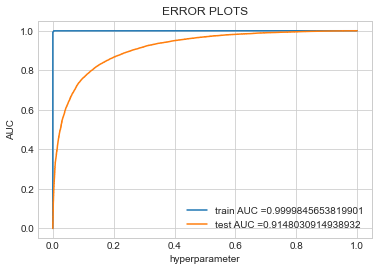

Train confusion matrix
[[33405    93]
 [   42 33460]]
Test confusion matrix
[[13901  2601]
 [ 2763 13735]]


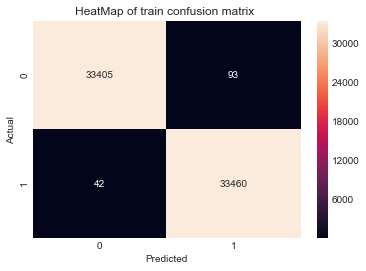

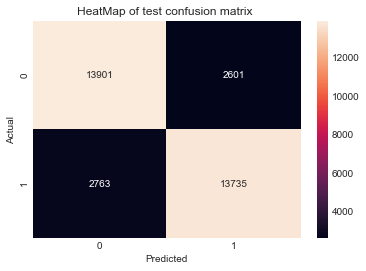

In [96]:
RF5=RandomForestClassifier(n_estimators=200,max_depth=20,n_jobs=-1,class_weight="balanced")
RF5.fit(sent_vectors_train, y_train)


train_fpr, train_tpr, thresholds = roc_curve(y_train,RF5.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,RF5.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("Train confusion matrix")
x=confusion_matrix(y_train, RF5.predict(sent_vectors_train))
y=confusion_matrix(y_test, RF5.predict(sent_vectors_test))
print(x)
print("Test confusion matrix")
print(y)


ax = plt.axes()
sns.heatmap(x, ax = ax,annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.set_title("HeatMap of train confusion matrix ")
plt.show()

ax = plt.axes()
sns.heatmap(y, ax = ax,annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.set_title("HeatMap of test confusion matrix ")
plt.show()

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [127]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)

dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

w2v_words = list(w2v_model.wv.vocab)

tfidf_feat = model.get_feature_names()
tfidf_sent_vectors = [];
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

tfidf_sent_vectors_test = [];
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33000/33000 [11:34<00:00, 47.50it/s]


In [98]:
x=[]
for i in range(1,33):
    x.append(i)

In [99]:
RF7=RandomForestClassifier( n_jobs=-1,class_weight="balanced")
parameters ={'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200],'max_depth':x}
clf4 = GridSearchCV(RF7, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf4.fit(tfidf_sent_vectors, y_train)
print(clf4.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=21, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)


In [152]:
max_depth_list = list(clf4.cv_results_['param_max_depth'].data)
n_estimators_list = list(clf4.cv_results_['param_n_estimators'].data)
train_Auc_score=clf4.cv_results_['mean_train_score']
cv_Auc_score=clf4.cv_results_['mean_test_score']
train_data=pd.DataFrame(data={'n_estimators':n_estimators_list, 'Max Depth':max_depth_list, 'AUC':train_Auc_score})
cv_data = pd.DataFrame(data={'n_estimators':n_estimators_list, 'Max Depth':max_depth_list, 'AUC':cv_Auc_score})

In [153]:
x1 = n_estimators_list
y1 = max_depth_list
z1 = train_Auc_score

x2 = n_estimators_list
y2 = max_depth_list
z2 = cv_Auc_score

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

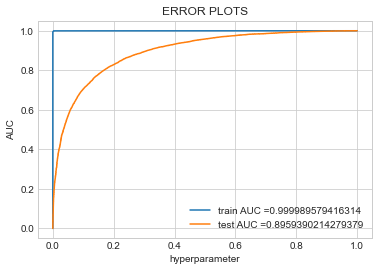

Train confusion matrix
[[33414    84]
 [   25 33477]]
Test confusion matrix
[[13522  2980]
 [ 3090 13408]]


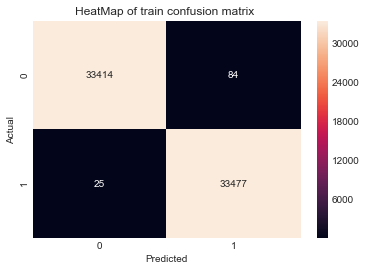

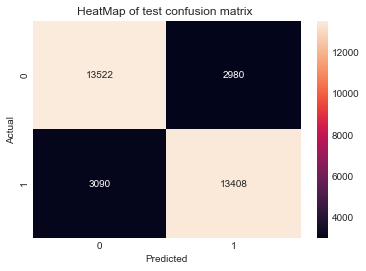

In [104]:
RF5=RandomForestClassifier(n_estimators=200,max_depth=21,n_jobs=-1,class_weight="balanced")
RF5.fit(tfidf_sent_vectors, y_train)


train_fpr, train_tpr, thresholds = roc_curve(y_train,RF5.predict_proba(tfidf_sent_vectors)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,RF5.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("Train confusion matrix")
x=confusion_matrix(y_train, RF5.predict(tfidf_sent_vectors))
y=confusion_matrix(y_test, RF5.predict(tfidf_sent_vectors_test))
print(x)
print("Test confusion matrix")
print(y)


ax = plt.axes()
sns.heatmap(x, ax = ax,annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.set_title("HeatMap of train confusion matrix ")
plt.show()

ax = plt.axes()
sns.heatmap(y, ax = ax,annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.set_title("HeatMap of test confusion matrix ")
plt.show()

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [108]:
x=[]
for i in range(1,33):
    x.append(i)

In [110]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.1)
parameters ={'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200],'max_depth':x}
clf5 = GridSearchCV(xgb, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf5.fit(X_train_bow, y_train)
print(clf5.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=30,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [111]:
max_depth_list = list(clf5.cv_results_['param_max_depth'].data)
n_estimators_list = list(clf5.cv_results_['param_n_estimators'].data)
train_Auc_score=clf5.cv_results_['mean_train_score']
cv_Auc_score=clf5.cv_results_['mean_test_score']
train_data=pd.DataFrame(data={'n_estimators':n_estimators_list, 'Max Depth':max_depth_list, 'AUC':train_Auc_score})
cv_data = pd.DataFrame(data={'n_estimators':n_estimators_list, 'Max Depth':max_depth_list, 'AUC':cv_Auc_score})

In [112]:
x1 = n_estimators_list
y1 = max_depth_list
z1 = train_Auc_score

x2 = n_estimators_list
y2 = max_depth_list
z2 = cv_Auc_score

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

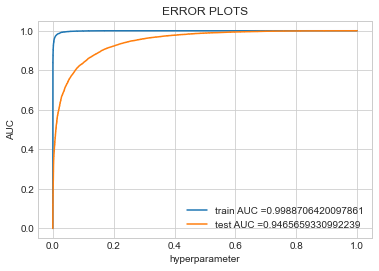

Train confusion matrix
[[33110   388]
 [  754 32748]]
Test confusion matrix
[[14530  1972]
 [ 2274 14224]]


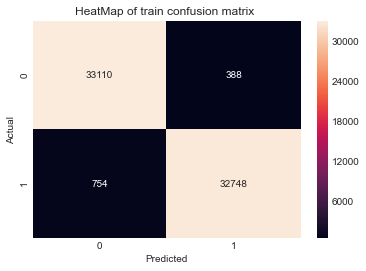

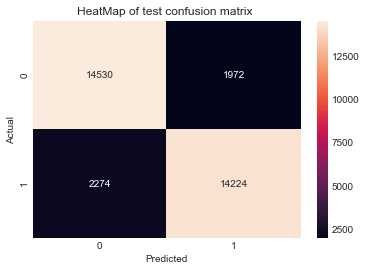

In [113]:
xgb1=XGBClassifier(n_estimators=200,max_depth=30,learning_rate=0.1)
xgb1.fit(X_train_bow, y_train)


train_fpr, train_tpr, thresholds = roc_curve(y_train,xgb1.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,xgb1.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("Train confusion matrix")
x=confusion_matrix(y_train, xgb1.predict(X_train_bow))
y=confusion_matrix(y_test, xgb1.predict(X_test_bow))
print(x)
print("Test confusion matrix")
print(y)


ax = plt.axes()
sns.heatmap(x, ax = ax,annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.set_title("HeatMap of train confusion matrix ")
plt.show()

ax = plt.axes()
sns.heatmap(y, ax = ax,annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.set_title("HeatMap of test confusion matrix ")
plt.show()

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

In [116]:
x = [*range(1, 33, 1)] 

In [117]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.1)
parameters ={'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200],'max_depth':x}
clf6 = GridSearchCV(xgb, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf6.fit(X_train_tfidf, y_train)
print(clf6.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=23,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [118]:
max_depth_list = list(clf6.cv_results_['param_max_depth'].data)
n_estimators_list = list(clf6.cv_results_['param_n_estimators'].data)
train_Auc_score=clf6.cv_results_['mean_train_score']
cv_Auc_score=clf6.cv_results_['mean_test_score']
train_data=pd.DataFrame(data={'n_estimators':n_estimators_list, 'Max Depth':max_depth_list, 'AUC':train_Auc_score})
cv_data = pd.DataFrame(data={'n_estimators':n_estimators_list, 'Max Depth':max_depth_list, 'AUC':cv_Auc_score})

In [119]:
x1 = n_estimators_list
y1 = max_depth_list
z1 = train_Auc_score

x2 = n_estimators_list
y2 = max_depth_list
z2 = cv_Auc_score

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

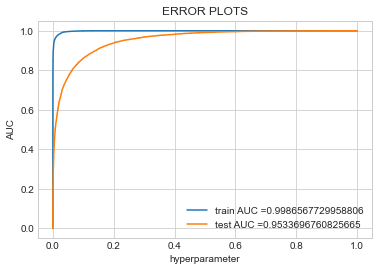

Train confusion matrix
[[32974   524]
 [  775 32727]]
Test confusion matrix
[[14668  1834]
 [ 2105 14393]]


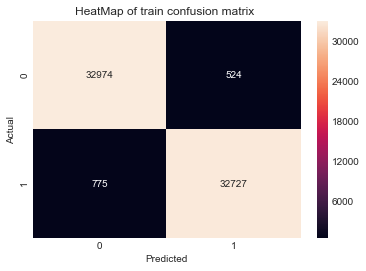

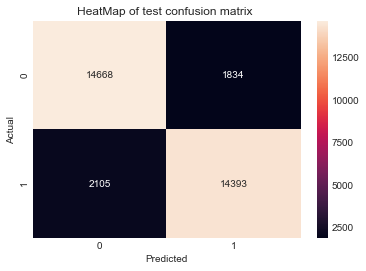

In [120]:
xgb1=XGBClassifier(n_estimators=200,max_depth=23,learning_rate=0.1)
xgb1.fit(X_train_tfidf, y_train)


train_fpr, train_tpr, thresholds = roc_curve(y_train,xgb1.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,xgb1.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("Train confusion matrix")
x=confusion_matrix(y_train, xgb1.predict(X_train_tfidf))
y=confusion_matrix(y_test, xgb1.predict(X_test_tfidf))
print(x)
print("Test confusion matrix")
print(y)


ax = plt.axes()
sns.heatmap(x, ax = ax,annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.set_title("HeatMap of train confusion matrix ")
plt.show()

ax = plt.axes()
sns.heatmap(y, ax = ax,annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.set_title("HeatMap of test confusion matrix ")
plt.show()

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [121]:
x = [*range(1, 33, 1)] 
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.1)
parameters ={'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200],'max_depth':x}
clf7 = GridSearchCV(xgb, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf7.fit(sent_vectors_train, y_train)
print(clf7.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [122]:
max_depth_list = list(clf7.cv_results_['param_max_depth'].data)
n_estimators_list = list(clf7.cv_results_['param_n_estimators'].data)
train_Auc_score=clf7.cv_results_['mean_train_score']
cv_Auc_score=clf7.cv_results_['mean_test_score']

In [123]:
x1 = n_estimators_list
y1 = max_depth_list
z1 = train_Auc_score

x2 = n_estimators_list
y2 = max_depth_list
z2 = cv_Auc_score

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

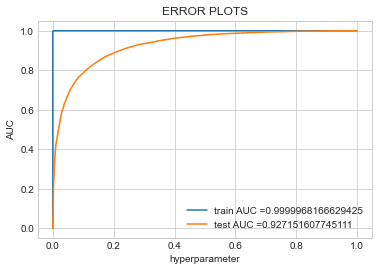

Train confusion matrix
[[33424    74]
 [    1 33501]]
Test confusion matrix
[[14075  2427]
 [ 2570 13928]]


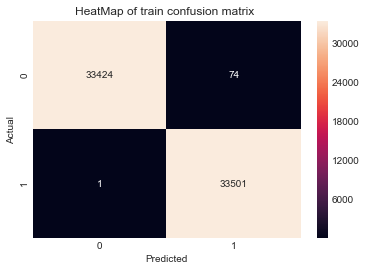

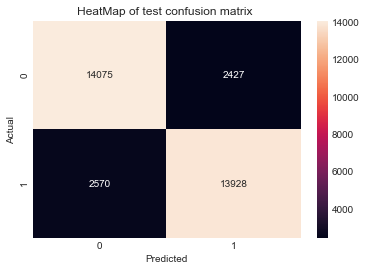

In [124]:
xgb1=XGBClassifier(n_estimators=200,max_depth=11,learning_rate=0.1)
xgb1.fit(sent_vectors_train, y_train)


train_fpr, train_tpr, thresholds = roc_curve(y_train,xgb1.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,xgb1.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("Train confusion matrix")
x=confusion_matrix(y_train, xgb1.predict(sent_vectors_train))
y=confusion_matrix(y_test, xgb1.predict(sent_vectors_test))
print(x)
print("Test confusion matrix")
print(y)


ax = plt.axes()
sns.heatmap(x, ax = ax,annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.set_title("HeatMap of train confusion matrix ")
plt.show()

ax = plt.axes()
sns.heatmap(y, ax = ax,annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.set_title("HeatMap of test confusion matrix ")
plt.show()

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [141]:
tfidf_sent_vectors_a=np.array(tfidf_sent_vectors) 
tfidf_sent_vectors_test_a=np.array(tfidf_sent_vectors_test)

In [142]:
x = [*range(1, 33, 1)] 
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.1)
parameters ={'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200],'max_depth':x}
clf8 = GridSearchCV(xgb, parameters, cv=3, scoring='roc_auc',return_train_score=True)
clf8.fit(tfidf_sent_vectors_a, y_train)
print(clf8.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [143]:
max_depth_list = list(clf8.cv_results_['param_max_depth'].data)
n_estimators_list = list(clf8.cv_results_['param_n_estimators'].data)
train_Auc_score=clf8.cv_results_['mean_train_score']
cv_Auc_score=clf8.cv_results_['mean_test_score']

In [144]:
x1 = n_estimators_list
y1 = max_depth_list
z1 = train_Auc_score

x2 = n_estimators_list
y2 = max_depth_list
z2 = cv_Auc_score

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=x1,y=y1,z=z1, name = 'train')
trace2 = go.Scatter3d(x=x2,y=y2,z=z2, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='n_estimators'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

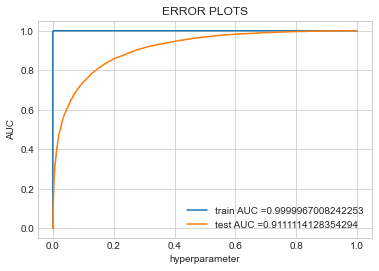

Train confusion matrix
[[33422    76]
 [    1 33501]]
Test confusion matrix
[[13791  2711]
 [ 2875 13623]]


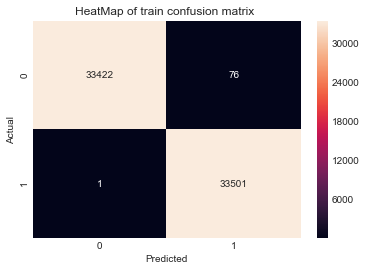

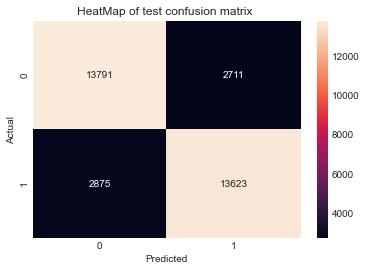

In [145]:
xgb1=XGBClassifier(n_estimators=200,max_depth=11,learning_rate=0.1)
xgb1.fit(tfidf_sent_vectors_a, y_train)


train_fpr, train_tpr, thresholds = roc_curve(y_train,xgb1.predict_proba(tfidf_sent_vectors_a)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,xgb1.predict_proba(tfidf_sent_vectors_test_a)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("Train confusion matrix")
x=confusion_matrix(y_train, xgb1.predict(tfidf_sent_vectors_a))
y=confusion_matrix(y_test, xgb1.predict(tfidf_sent_vectors_test_a))
print(x)
print("Test confusion matrix")
print(y)


ax = plt.axes()
sns.heatmap(x, ax = ax,annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.set_title("HeatMap of train confusion matrix ")
plt.show()

ax = plt.axes()
sns.heatmap(y, ax = ax,annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
ax.set_title("HeatMap of test confusion matrix ")
plt.show()

# [6] Conclusions

In [173]:
from prettytable import PrettyTable


x = PrettyTable()
x.field_names = ["Model","Vectorizer","Hyper Parameter(max_depth)","Hyper Parameter(n_estimators)","AUC"]
x.add_row(["RandomForestClassifier","BOW","32","200","0.9371"])
x.add_row(["RandomForestClassifier","TF-IDF","13","200","0.9188"])
x.add_row(["RandomForestClassifier","AVG W2V","20","200","0.9148"])
x.add_row(["RandomForestClassifier","TFIDF W2V","21","200","0.8959"])
print(x)


y = PrettyTable()
y.field_names = ["Model","Vectorizer","Hyper Parameter(max_depth)","Hyper Parameter(n_estimators)","Hyper Parameter(learning_rate)","AUC"]
y.add_row(["XGBOOST","BOW","30","200","0.1","0.9455"])
y.add_row(["XGBOOST","TF-IDF","23","200","0.1","0.9533"])
y.add_row(["XGBOOST","AVG W2V","11","200","0.1","0.9271"])
y.add_row(["XGBOOST","TFIDF W2V","11","200","0.1","0.9111"])
print(y)

+------------------------+------------+----------------------------+-------------------------------+--------+
|         Model          | Vectorizer | Hyper Parameter(max_depth) | Hyper Parameter(n_estimators) |  AUC   |
+------------------------+------------+----------------------------+-------------------------------+--------+
| RandomForestClassifier |    BOW     |             32             |              200              | 0.9371 |
| RandomForestClassifier |   TF-IDF   |             13             |              200              | 0.9188 |
| RandomForestClassifier |  AVG W2V   |             20             |              200              | 0.9148 |
| RandomForestClassifier | TFIDF W2V  |             21             |              200              | 0.8959 |
+------------------------+------------+----------------------------+-------------------------------+--------+
+---------+------------+----------------------------+-------------------------------+--------------------------------+--

### Observations:- 

### The behaviour of the models corresponding to all the vectorizers was similar best performance was observed with TFIDF  vectorizers 

### Feature importance was observed using the inbuilt Model Attribute